# Late fusion pipeline

## Setup

In [1]:
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, recall_score

### Paths

In [2]:
input_path = '../../../2.data_preparation/out/'
global_output_path = '../out/'
output_path = '../out/fusion/'
# Global configuration path
glob_conf_path = '../../../config/global_config_paper.py'

### Load global variables

In [3]:
exec(open(glob_conf_path).read())

### Other functions

In [4]:
from sklearn.metrics import confusion_matrix

def plot_save_conf_matrix(conf_mat, title, file_name, report=False):
    df_cm = pd.DataFrame(conf_mat, list(emotion_eng_id_to_emotion_num.keys()), list(emotion_eng_id_to_emotion_num.keys()))
    df_cm = df_cm.reindex(sorted(df_cm.columns)).reindex(sorted(df_cm.columns), axis=1)
    
    plt.figure(figsize=(15,15))
    ax = sns.heatmap(df_cm, annot=True, fmt='.2f', vmin=0, vmax=1, cmap=conf_cmap)
    plt.yticks(va='center')
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    if report == True:
        plt.savefig(os.path.join(output_path,'confusion_matrix','report_'+file_name), bbox_inches = 'tight') 
    plt.title(title)
    plt.savefig(os.path.join(output_path,'confusion_matrix',file_name), bbox_inches = 'tight')    

### Load and shuffle data

In [5]:
from sklearn.utils import shuffle

train_video_df = pd.read_csv(os.path.join(input_path, 'video', 'video_data_intensity_train.csv'))
train_audio_df = pd.read_csv(os.path.join(input_path, 'audio', 'egemaps', 'audio_data_egemaps_train.csv'))

train_video_shuffled_df = shuffle(train_video_df, random_state=seed).reset_index(drop=True)
train_audio_shuffled_df = shuffle(train_audio_df, random_state=seed).reset_index(drop=True)

In [6]:
train_audio_shuffled_df

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,actor_id,file_id,target,group
0,0.240379,0.614553,0.089265,0.219347,0.284260,0.280270,0.303624,0.200022,0.262954,0.033284,...,0.235860,0.045146,0.114542,0.072464,0.140819,0.082002,3,315,9,3
1,0.428243,0.121044,0.397641,0.397569,0.437531,0.122617,0.148100,0.015786,0.218510,0.011256,...,0.311049,0.026147,0.037864,0.115942,0.204594,0.731306,9,1117,15,4
2,0.499724,0.243378,0.437738,0.420981,0.586214,0.260613,0.142826,0.018867,0.205943,0.003317,...,0.134254,0.114960,0.138889,0.043478,0.000000,0.478746,8,987,14,5
3,0.294653,0.605192,0.026334,0.314250,0.475608,0.586494,0.137131,0.002755,0.226926,0.000000,...,0.378653,0.019025,0.143761,0.100644,0.155143,0.633834,9,1067,9,4
4,0.154184,0.620439,0.076768,0.134368,0.172950,0.157283,0.179695,0.035599,0.277163,0.124323,...,0.240382,0.047964,0.202761,0.067391,0.060728,0.159401,3,323,9,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,0.800665,0.175227,0.745947,0.790104,0.808547,0.188162,0.173931,0.011665,0.205735,0.023853,...,0.100549,0.115733,0.295122,0.115942,0.090744,0.838798,2,141,3,1
1255,0.339490,0.457571,0.146215,0.395539,0.453824,0.425043,0.180069,0.018150,0.230690,0.016112,...,0.275777,0.033870,0.113277,0.076812,0.033838,0.792443,9,1049,6,4
1256,0.628904,0.354822,0.665858,0.633961,0.696183,0.139788,0.381234,0.154791,0.274983,0.100322,...,0.386604,0.024603,0.093439,0.082609,0.087039,0.584423,6,753,17,2
1257,0.663620,0.149773,0.618283,0.661143,0.654561,0.141982,0.142250,0.015549,0.208364,0.004063,...,0.105917,0.096812,0.233341,0.230072,0.270494,0.694067,5,543,6,3


## Late fusion configuration

### Audio and video classifiers 

In [7]:
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier


# We can not just load the best video and audio models, otherwise the pipeline AUC_avg would be biased.
# We use the obtained parameters from audio_modeling and video_modeling. 

# Define a new audio classifier with the best parameters found during the audio modeling 
file_path = os.path.join('../out/audio/', 'best_params','best_params_elastic_net_egemaps_audio.sav')
best_params_audio = pickle.load(open(file_path, 'rb'))
audio_clf = SGDClassifier(**best_params_audio)

# Define a new video classifier with the best parameters found during the video modeling 
file_path = os.path.join('../out/video/', 'best_params','best_params_rf_intensity_video.sav')
best_params_video = pickle.load(open(file_path, 'rb'))
video_clf = RandomForestClassifier(**best_params_video)

In [8]:
print(best_params_audio)
print()
print(best_params_video)

{'alpha': 0.00075, 'class_weight': 'balanced', 'l1_ratio': 0.3, 'loss': 'log', 'max_iter': 2500, 'n_iter_no_change': 100, 'penalty': 'elasticnet', 'random_state': 27}

{'random_state': 27, 'n_jobs': -1, 'n_estimators': 495, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 110, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': True}


### Pipeline Class

In [9]:
class PipelineLateFusion:
    def __init__(self, audio_clf, video_clf, fusion_tech='sum', fusion_clf=None, audio_weight_ratio=0.15):
        # Input audio and video classifiers
        self.audio_model            = audio_clf
        self.video_model            = video_clf
        
        self.fusion_technique       = fusion_tech
        
        # Classifier fusion technique variables
        self.fusion_model           = fusion_clf
        
        # Weighted average fusion technique variables
        try:
            if audio_weight_ratio>=0 and audio_weight_ratio<=1:
                self.audio_weight_ratio = audio_weight_ratio
            else:
                raise
        except:
            print('Error: audio_weight_ratio must be between 0 and 1.')
            raise
            
            
    def predict(self, X_audio_df, X_video_df):
        audio_clf  = self.audio_model
        video_clf  = self.video_model
        fusion_clf = self.fusion_model
        
        audio_scores = audio_clf.predict_proba(X_audio_df)
        video_scores = video_clf.predict_proba(X_video_df)
        
        # Fusing techniques
        if   self.fusion_technique == 'sum':                              # Sum rule
            avg = ((audio_scores + video_scores) / 2)                     # Average scores
            out = avg.argmax(axis=1)                                      # Get classes
    
        elif self.fusion_technique == 'weight_crit':                      # Weight criterion
            audio_ratio = self.audio_weight_ratio                         # Get audio ratio
            video_ratio = 1 - self.audio_weight_ratio                     # Get video ratio
            avg = (audio_ratio*audio_scores + video_ratio*video_scores)   # Compute weighted scores
            out = avg.argmax(axis=1)                                      # Get classes
            
        elif self.fusion_technique == 'max':                              # Max rule
            max_pred = np.amax([audio_scores, video_scores], axis=0)      # Get max value rowise (between classifiers)
            max_norm = max_pred / max_pred.sum(axis=1)[:,None]            # Normalize predictions
            out = max_norm.argmax(axis=1)                                 # Get classes
        
        elif self.fusion_technique == 'prod':                             # Product rule
            prod = audio_scores*video_scores                              # Get product value rowise (between classifiers)
            prod_norm = prod / prod.sum(axis=1)[:,None]                   # Normalize predictions
            out = prod_norm.argmax(axis=1)                                # Get classes
        
        elif self.fusion_technique == 'rule':                             # Rule-based (I choose classifier according to validation confusion matrix)
            rul = np.column_stack((audio_scores[:,0],                     # adm emotion --> audio
                                   audio_scores[:,1],                     # amu emotion --> audio
                                   audio_scores[:,2],                     # att emotion --> audio
                                   video_scores[:,3],                     # col emotion --> video
                                   video_scores[:,4],                     # deg emotion --> video
                                   audio_scores[:,5],                     # des emotion --> audio
                                   audio_scores[:,6],                     # fie emotion --> audio
                                   audio_scores[:,7],                     # hon emotion --> audio
                                   video_scores[:,8],                     # inq emotion --> video
                                   audio_scores[:,9],                     # int emotion --> audio
                                   video_scores[:,10],                    # irr emotion --> video
                                   video_scores[:,11],                    # joi emotion --> video
                                   video_scores[:,12],                    # mep emotion --> video
                                   audio_scores[:,13],                    # peu emotion --> audio
                                   audio_scores[:,14],                    # pla emotion --> audio
                                   audio_scores[:,15],                    # sou emotion --> audio
                                   video_scores[:,16],                    # sur emotion --> video
                                   video_scores[:,17]                     # tri emotion --> video
                                   ))
            rul_norm = rul / rul.sum(axis=1)[:,None]                      # Normalize predictions
            out = rul_norm.argmax(axis=1)                                 # Get classes
            
        elif self.fusion_technique == 'clf':                              # Use trained classifier to predict the output probabilities
            try:
                if self.fusion_model is None:
                    raise
            except:
                print('Error: No fusing classifier was found.')

            out = fusion_clf.predict_proba(np.column_stack((audio_scores,video_scores)))
            out = out.argmax(axis=1)
        
        return out
        
        
    def predict_proba(self, X_audio_df, X_video_df):
        audio_clf  = self.audio_model
        video_clf  = self.video_model
        fusion_clf = self.fusion_model
        
        audio_scores = audio_clf.predict_proba(X_audio_df)
        video_scores = video_clf.predict_proba(X_video_df)
        
        # Fusing techniques
        if   self.fusion_technique == 'sum':                              # Average probabilities
            out = ((audio_scores + video_scores) / 2)                     # Average scores
            
        elif self.fusion_technique == 'weight_crit':                      # Weight criterion
            audio_ratio = self.audio_weight_ratio                         # Get audio ratio
            video_ratio = 1 - self.audio_weight_ratio                     # Get video ratio
            out = (audio_ratio*audio_scores + video_ratio*video_scores)   # Compute weighted scores
        
        elif self.fusion_technique == 'max':                              # Max rule
            max_pred = np.amax([audio_scores, video_scores], axis=0)      # Get max value rowise (between classifiers)
            out = max_pred / max_pred.sum(axis=1)[:,None]                 # Normalize predictions
        
        elif self.fusion_technique == 'prod':                             # Product rule
            prod = audio_scores*video_scores                              # Get product value rowise (between classifiers)
            out = prod / prod.sum(axis=1)[:,None]                         # Normalize predictions
        
        elif self.fusion_technique == 'rule':                             # Rule-based (I choose classifier according to validation confusion matrix)
            rul = np.column_stack((audio_scores[:,0],                     # adm emotion --> audio
                                   audio_scores[:,1],                     # amu emotion --> audio
                                   audio_scores[:,2],                     # att emotion --> audio
                                   video_scores[:,3],                     # col emotion --> video
                                   video_scores[:,4],                     # deg emotion --> video
                                   audio_scores[:,5],                     # des emotion --> video
                                   audio_scores[:,6],                     # fie emotion --> audio
                                   audio_scores[:,7],                     # hon emotion --> video
                                   video_scores[:,8],                     # inq emotion --> video
                                   audio_scores[:,9],                     # int emotion --> audio
                                   video_scores[:,10],                    # irr emotion --> audio
                                   video_scores[:,11],                    # joi emotion --> audio
                                   video_scores[:,12],                    # mep emotion --> video
                                   audio_scores[:,13],                    # peu emotion --> audio
                                   audio_scores[:,14],                    # pla emotion --> audio
                                   audio_scores[:,15],                    # sou emotion --> audio
                                   video_scores[:,16],                    # sur emotion --> video
                                   video_scores[:,17]                     # tri emotion --> video
                                   ))
            out = rul / rul.sum(axis=1)[:,None]                           # Normalize predictions
        
        elif self.fusion_technique == 'clf':                              # Use trained classifier to predict the output probabilities
            try:
                if self.fusion_model is None:
                    raise
            except:
                print('Error: No fusing classifier was found.')

            out  = fusion_clf.predict_proba(np.column_stack((audio_scores,video_scores)))
        
        return out
    
    def show(self):
        print('Audio model:', self.audio_model)
        print()
        print('Video model:', self.video_model)
        print()
        print('Fusing model:', self.fusion_model)

## Fusion techniques

### Sum rule

AUC_avg (train): 0.997227060996263
AUC_std (train): 0.00020554924159348016
AUC_avg (validation): 0.8618312108844789
AUC_std (validation): 0.012755667244767448
UAR_avg (train): 0.9488936706659711
UAR_std (train): 0.00338749183631023
UAR_avg (validation): 0.33580246913580253
UAR_std (validation): 0.02464501824404583


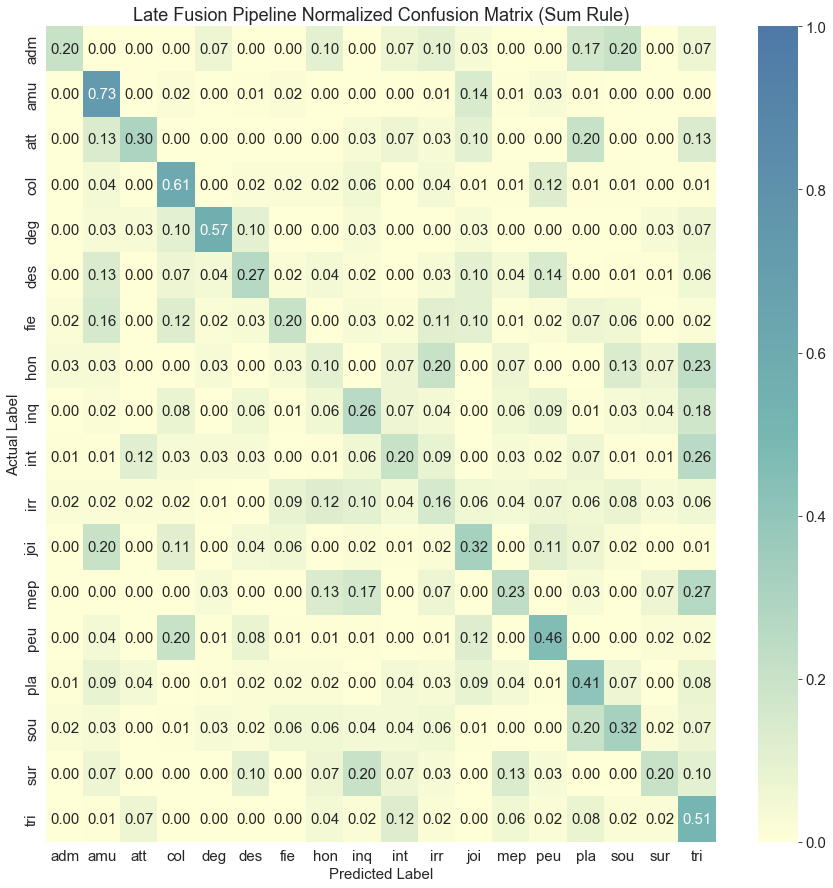

In [11]:
# Obtain X, y, and groups from the training dataset
X_audio_df = train_audio_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_audio_df = train_audio_shuffled_df.target
X_video_df = train_video_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_video_df = train_video_shuffled_df.target
groups = train_video_shuffled_df.group
n_groups = len(groups.unique())

logo = LeaveOneGroupOut()


# Initialize some variables to store results
results = []
AUC_train = []
AUC_val = []
UAR_train = []
UAR_val = []
conf_mat_avg = np.zeros([18,18])
for train_idx, val_idx in logo.split(X_audio_df, y_audio_df, groups):
    X_train_audio, X_val_audio, y_train, y_val = X_audio_df.iloc[train_idx], X_audio_df.iloc[val_idx], y_audio_df.iloc[train_idx], y_audio_df.iloc[val_idx]
    X_train_video, X_val_video, y_train, y_val = X_video_df.iloc[train_idx], X_video_df.iloc[val_idx], y_video_df.iloc[train_idx], y_video_df.iloc[val_idx]
    
    # Fit models and create pipeline
    audio_clf.fit(X_train_audio, y_train)
    video_clf.fit(X_train_video, y_train)
    pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf,
                                          video_clf   = video_clf,
                                          fusion_clf  = None,
                                          fusion_tech = 'sum'
                                         )
    
    # AUC - Compute results (training set)
    scores = pipe_late_fusion.predict_proba(X_audio_df = X_train_audio, # Predict probabilities
                                            X_video_df = X_train_video
                                           ) 
    AUC_tmp = roc_auc_score(y_true=y_train,                             # Compute AUC score
                            y_score=scores,
                            average='weighted',
                            multi_class='ovo')     
    AUC_train.append(AUC_tmp) 
    
    # UAR - Compute results (training set)
    predictions = pipe_late_fusion.predict(X_audio_df = X_train_audio,
                                           X_video_df = X_train_video)
    UAR_tmp = recall_score(y_true  = y_train,
                           y_pred  = predictions,
                           average = 'macro')
    UAR_train.append(UAR_tmp)
    
    
    # AUC - Compute results (validation set)
    scores = pipe_late_fusion.predict_proba(X_audio_df = X_val_audio, # Predict probabilities
                                            X_video_df = X_val_video
                                           ) 
    AUC_tmp = roc_auc_score(y_true=y_val,                             # Compute AUC score
                            y_score=scores,
                            average='weighted',
                            multi_class='ovo')     
    AUC_val.append(AUC_tmp)                                               # Add the new AUC to the array
    
    # UAR - Compute results (validation set)
    predictions = pipe_late_fusion.predict(X_audio_df = X_val_audio,
                                           X_video_df = X_val_video)
    UAR_tmp = recall_score(y_true  = y_val,
                           y_pred  = predictions,
                           average = 'macro')
    UAR_val.append(UAR_tmp)

    
    # Confusion Matrix - Compute results (validation set)
    y_pred = pipe_late_fusion.predict(X_audio_df = X_val_audio,       # Predict class
                                      X_video_df = X_val_video
                                     )                       
    conf_mat_tmp = confusion_matrix(y_val,                            # Compute confusion matrix for this batch
                                    y_pred,
                                    normalize='true'
                                    )
    conf_mat_avg += conf_mat_tmp    

AUC_train_avg, AUC_train_std = np.mean(AUC_train), np.std(AUC_train)   # Compute the arithmetic mean and the std of the AUC array (Training)
AUC_val_avg, AUC_val_std = np.mean(AUC_val), np.std(AUC_val)   # Compute the arithmetic mean and the std of the AUC array (Validation)
UAR_train_avg, UAR_train_std = np.mean(UAR_train), np.std(UAR_train)   # Compute the arithmetic mean and the std of the AUC array (Training)
UAR_val_avg, UAR_val_std = np.mean(UAR_val), np.std(UAR_val)   # Compute the arithmetic mean and the std of the AUC array (Validation)
conf_mat_avg /= n_groups # Compute the arithmetic mean of the confusion matrix

# Add results to the results list
results.append(['sum',                             # fusion_tech
                AUC_train_avg,
                AUC_train_std,
                AUC_val_avg,
                AUC_val_std,
                UAR_train_avg,
                UAR_train_std,
                UAR_val_avg,
                UAR_val_std
               ])

        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['fusion_tech','AUC_train_avg','AUC_train_std','AUC_val_avg','AUC_val_std','UAR_train_avg','UAR_train_std','UAR_val_avg','UAR_val_std'])
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_late_fusion_sum_'+str(n_groups)+'_logocv.csv'), index=None, header=True)
print('AUC_avg (train):', results_df['AUC_train_avg'].values[0])
print('AUC_std (train):', results_df['AUC_train_std'].values[0])
print('AUC_avg (validation):', results_df['AUC_val_avg'].values[0])
print('AUC_std (validation):', results_df['AUC_val_std'].values[0])
print('UAR_avg (train):', results_df['UAR_train_avg'].values[0])
print('UAR_std (train):', results_df['UAR_train_std'].values[0])
print('UAR_avg (validation):', results_df['UAR_val_avg'].values[0])
print('UAR_std (validation):', results_df['UAR_val_std'].values[0])

# Store the confusion matrix in a DataFrame and then plot it and save it
plot_save_conf_matrix(conf_mat_avg,
                      title = 'Late Fusion Pipeline Normalized Confusion Matrix (Sum Rule)',
                      file_name = 'conf_mat_pipeline_late_fusion_sum.svg')

### Weight Criterion

In [10]:
# Obtain X, y, and groups from the training dataset
X_audio_df = train_audio_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_audio_df = train_audio_shuffled_df.target
X_video_df = train_video_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_video_df = train_video_shuffled_df.target
groups = train_video_shuffled_df.group
n_groups = len(groups.unique())

logo = LeaveOneGroupOut()


# Define parameters to evaluate (fusing parameters)
audio_weight_ratio_values =  np.arange(0, 1.05, 0.05).tolist()
parameters = [(audio_weight_ratio,) for audio_weight_ratio in audio_weight_ratio_values]


# Initialize some variables to store results
results = []
AUC_best_model = 0
params_best_model = None
for i in tqdm(range(len(parameters))):
    AUC = []
    
    for train_idx, val_idx in logo.split(X_audio_df, y_audio_df, groups):
        X_train_audio, X_val_audio, y_train, y_val = X_audio_df.iloc[train_idx], X_audio_df.iloc[val_idx], y_audio_df.iloc[train_idx], y_audio_df.iloc[val_idx]
        X_train_video, X_val_video, y_train, y_val = X_video_df.iloc[train_idx], X_video_df.iloc[val_idx], y_video_df.iloc[train_idx], y_video_df.iloc[val_idx]
    
        # Fit models and create pipeline
        audio_clf.fit(X_train_audio, y_train)
        video_clf.fit(X_train_video, y_train)
        pipe_late_fusion = PipelineLateFusion(audio_clf          = audio_clf,
                                              video_clf          = video_clf,
                                              fusion_clf         = None,
                                              fusion_tech        = 'weight_crit',
                                              audio_weight_ratio = parameters[i][0]
                                             )
        
        
        # Compute results (validation dataset)
        scores = pipe_late_fusion.predict_proba(X_audio_df = X_val_audio, # Predict probabilities
                                                X_video_df = X_val_video
                                               ) 
        AUC_tmp = roc_auc_score(y_true=y_val,
                                y_score=scores,
                                average='weighted',
                                multi_class='ovo')                        # Get AUC score
        AUC.append(AUC_tmp)
        #print(AUC_tmp)
    AUC_avg = np.mean(AUC)                                                # Get average AUC
    AUC_std = np.std(AUC)                                                 # Get std AUC
    AUC_avg_minus_std = AUC_avg - AUC_std
    
    # Add results to the results list
    results.append([parameters[i][0],                                        # audio_weight_ratio
                    AUC_avg,
                    AUC_std,
                    AUC_avg_minus_std
                   ])
    
    # Check if the current AUC_avg - AUC_std is better that the one stored
    if AUC_avg_minus_std > AUC_best_model:
        AUC_best_model = AUC_avg_minus_std      # Update best AUC
        params_best_model = parameters[i]           # Update best model parameters


        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['audio_weight_ratio','AUC_avg','AUC_std','AUC_avg_minus_std'])
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_late_fusion_weight_crit_'+str(n_groups)+'_logocv.csv'), index=None, header=True)

100%|██████████| 21/21 [29:00<00:00, 82.86s/it]


In [11]:
results_df.sort_values(by='AUC_avg_minus_std', ascending=False).head()

,audio_weight_ratio,AUC_avg,AUC_std,AUC_avg_minus_std
9,0.45,0.862357,0.012909,0.849448
10,0.50,0.861831,0.012756,0.849076
11,0.55,0.861097,0.012515,0.848582
8,0.40,0.861673,0.013361,0.848312
12,0.60,0.859398,0.012428,0.846969


AUC_avg (train): 0.9981043821828784
AUC_std (train): 0.00016551406286147084
AUC_avg (validation): 0.8623573330242618
AUC_std (validation): 0.012909494583932167
UAR_avg (train): 0.9637171796209355
UAR_std (train): 0.005588194510693197
UAR_avg (validation): 0.33086419753086427
UAR_std (validation): 0.03227633694420094


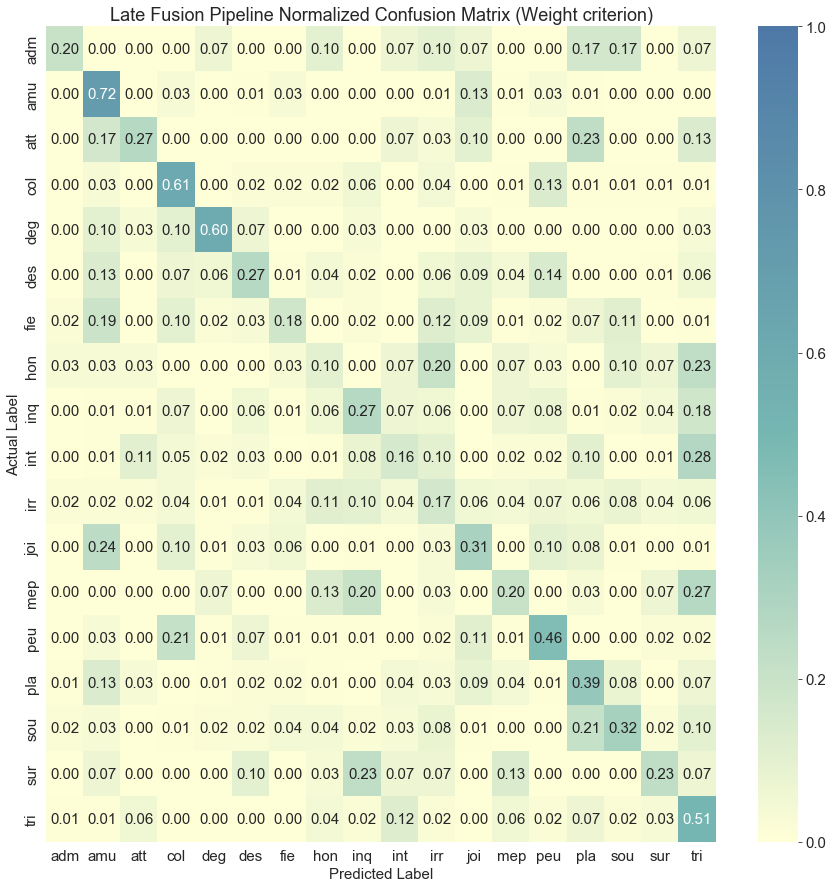

In [13]:
# Obtain X, y, and groups from the training dataset
X_audio_df = train_audio_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_audio_df = train_audio_shuffled_df.target
X_video_df = train_video_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_video_df = train_video_shuffled_df.target
groups = train_video_shuffled_df.group
n_groups = len(groups.unique())

logo = LeaveOneGroupOut()

# Load audio_weight_ratio of the best model
results_df = pd.read_csv(os.path.join(output_path,'results','res_pipeline_late_fusion_weight_crit_'+str(n_groups)+'_logocv.csv'))
audio_weight_ratio = results_df.sort_values(by='AUC_avg_minus_std', ascending=False)['audio_weight_ratio'].values[0]

# Initialize some variables to store results
AUC_train = []
AUC_val = []
UAR_train = []
UAR_val = []
conf_mat_avg = np.zeros([18,18])
for train_idx, val_idx in logo.split(X_audio_df, y_audio_df, groups):
    X_train_audio, X_val_audio, y_train, y_val = X_audio_df.iloc[train_idx], X_audio_df.iloc[val_idx], y_audio_df.iloc[train_idx], y_audio_df.iloc[val_idx]
    X_train_video, X_val_video, y_train, y_val = X_video_df.iloc[train_idx], X_video_df.iloc[val_idx], y_video_df.iloc[train_idx], y_video_df.iloc[val_idx]
     
    # Fit models and create pipeline
    audio_clf.fit(X_train_audio, y_train)
    video_clf.fit(X_train_video, y_train)
    pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf,
                                          video_clf   = video_clf,
                                          fusion_clf  = None,
                                          fusion_tech = 'weight_crit',
                                          audio_weight_ratio = audio_weight_ratio
                                         )
    
    # AUC - training
    scores = pipe_late_fusion.predict_proba(X_audio_df = X_train_audio, # Predict probabilities
                                            X_video_df = X_train_video
                                           ) 
    AUC_tmp = roc_auc_score(y_true=y_train,
                            y_score=scores,
                            average='weighted',
                            multi_class='ovo')                        # Get AUC score
    AUC_train.append(AUC_tmp)                                         # Add new AUC
    
    # UAR - Compute results (training set)
    predictions = pipe_late_fusion.predict(X_audio_df = X_train_audio,
                                           X_video_df = X_train_video)
    UAR_tmp = recall_score(y_true  = y_train,
                           y_pred  = predictions,
                           average = 'macro')
    UAR_train.append(UAR_tmp)
    
    
    # AUC - validation
    scores = pipe_late_fusion.predict_proba(X_audio_df = X_val_audio, # Predict probabilities
                                            X_video_df = X_val_video
                                           ) 
    AUC_tmp = roc_auc_score(y_true=y_val,
                            y_score=scores,
                            average='weighted',
                            multi_class='ovo')                        # Get AUC score
    AUC_val.append(AUC_tmp)                                           # Add new AUC
    
    # UAR - Compute results (validation set)
    predictions = pipe_late_fusion.predict(X_audio_df = X_val_audio,
                                           X_video_df = X_val_video)
    UAR_tmp = recall_score(y_true  = y_val,
                           y_pred  = predictions,
                           average = 'macro')
    UAR_val.append(UAR_tmp)
    
    
    # Confusion Matrix - Compute results (validation set)
    y_pred = pipe_late_fusion.predict(X_audio_df = X_val_audio,       # Predict class
                                      X_video_df = X_val_video
                                     )                       
    conf_mat_tmp = confusion_matrix(y_val,                            # Compute confusion matrix for this batch
                                    y_pred,
                                    normalize='true'
                                    )
    conf_mat_avg += conf_mat_tmp    
         
# Calculate final results: confusion matrix, AUC (train), AUC (test)
conf_mat_avg /= n_groups # Compute the arithmetic mean of the confusion matrix
auc_train_avg, auc_train_std = np.mean(AUC_train), np.std(AUC_train)
auc_val_avg, auc_val_std = np.mean(AUC_val), np.std(AUC_val)
uar_train_avg, uar_train_std = np.mean(UAR_train), np.std(UAR_train)   # Compute the arithmetic mean and the std of the AUC array (Training)
uar_val_avg, uar_val_std = np.mean(UAR_val), np.std(UAR_val)   # Compute the arithmetic mean and the std of the AUC array (Validation)


# Plot AUCs
print('AUC_avg (train):', auc_train_avg)
print('AUC_std (train):', auc_train_std)
print('AUC_avg (validation):', auc_val_avg)
print('AUC_std (validation):', auc_val_std)
print('UAR_avg (train):', uar_train_avg)
print('UAR_std (train):', uar_train_std)
print('UAR_avg (validation):', uar_val_avg)
print('UAR_std (validation):', uar_val_std)

# Store the confusion matrix in a DataFrame and then plot it and save it
plot_save_conf_matrix(conf_mat_avg,
                      title      = 'Late Fusion Pipeline Normalized Confusion Matrix (Weight criterion)',
                      file_name = 'conf_mat_pipeline_late_fusion_weight_crit.svg')

### Max rule

Selects the maximum of all posterior probabilities.

AUC_avg (train): 0.995984062582135
AUC_std (train): 0.00034299316689980375
AUC_avg (validation): 0.8359704265877728
AUC_std (validation): 0.011588525352598232
UAR_avg (train): 0.9272887323943662
UAR_std (train): 0.005310611994395441
UAR_avg (validation): 0.275998547567175
UAR_std (validation): 0.02240451194577666


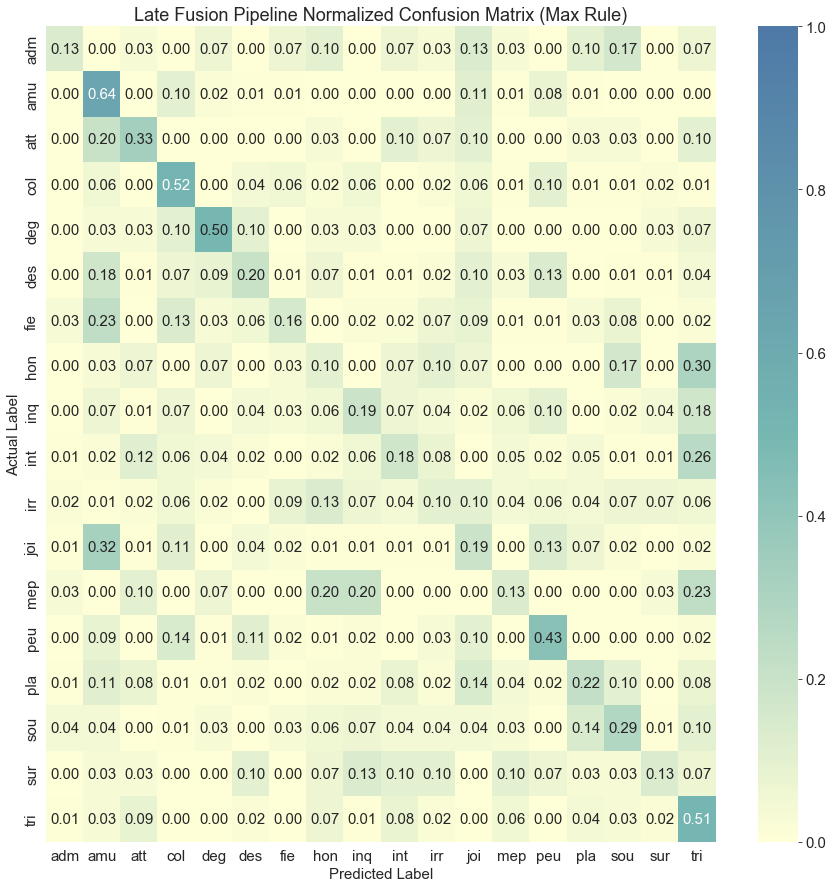

In [14]:
# Obtain X, y, and groups from the training dataset
X_audio_df = train_audio_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_audio_df = train_audio_shuffled_df.target
X_video_df = train_video_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_video_df = train_video_shuffled_df.target
groups = train_video_shuffled_df.group
n_groups = len(groups.unique())

logo = LeaveOneGroupOut()


# Initialize some variables to store results
results = []
AUC_train = []
AUC_val = []
UAR_train = []
UAR_val = []
conf_mat_avg = np.zeros([18,18])
for train_idx, val_idx in logo.split(X_audio_df, y_audio_df, groups):
    X_train_audio, X_val_audio, y_train, y_val = X_audio_df.iloc[train_idx], X_audio_df.iloc[val_idx], y_audio_df.iloc[train_idx], y_audio_df.iloc[val_idx]
    X_train_video, X_val_video, y_train, y_val = X_video_df.iloc[train_idx], X_video_df.iloc[val_idx], y_video_df.iloc[train_idx], y_video_df.iloc[val_idx]
    
    # Fit models and create pipeline
    audio_clf.fit(X_train_audio, y_train)
    video_clf.fit(X_train_video, y_train)
    pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf,
                                          video_clf   = video_clf,
                                          fusion_clf  = None,
                                          fusion_tech = 'max'
                                         )
    
    # AUC - Compute results (training set)
    scores = pipe_late_fusion.predict_proba(X_audio_df = X_train_audio, # Predict probabilities
                                            X_video_df = X_train_video
                                           ) 
    AUC_tmp = roc_auc_score(y_true=y_train,                             # Compute AUC score
                            y_score=scores,
                            average='weighted',
                            multi_class='ovo')     
    AUC_train.append(AUC_tmp)
    
    
    # UAR - Compute results (training set)
    predictions = pipe_late_fusion.predict(X_audio_df = X_train_audio,
                                           X_video_df = X_train_video)
    UAR_tmp = recall_score(y_true  = y_train,
                           y_pred  = predictions,
                           average = 'macro')
    UAR_train.append(UAR_tmp)
    
    
    # AUC - Compute results (validation set)
    scores = pipe_late_fusion.predict_proba(X_audio_df = X_val_audio, # Predict probabilities
                                            X_video_df = X_val_video
                                           ) 
    AUC_tmp = roc_auc_score(y_true=y_val,                             # Compute AUC score
                            y_score=scores,
                            average='weighted',
                            multi_class='ovo')     
    AUC_val.append(AUC_tmp)                                               # Add the new AUC to the array

    # UAR - Compute results (validation set)
    predictions = pipe_late_fusion.predict(X_audio_df = X_val_audio,
                                           X_video_df = X_val_video)
    UAR_tmp = recall_score(y_true  = y_val,
                           y_pred  = predictions,
                           average = 'macro')
    UAR_val.append(UAR_tmp)
    
    # Confusion Matrix - Compute results (validation set)
    y_pred = pipe_late_fusion.predict(X_audio_df = X_val_audio,       # Predict class
                                      X_video_df = X_val_video
                                     )                       
    conf_mat_tmp = confusion_matrix(y_val,                            # Compute confusion matrix for this batch
                                    y_pred,
                                    normalize='true'
                                    )
    conf_mat_avg += conf_mat_tmp    

AUC_train_avg, AUC_train_std = np.mean(AUC_train), np.std(AUC_train)   # Compute the arithmetic mean and the std of the AUC array (Training)
AUC_val_avg, AUC_val_std = np.mean(AUC_val), np.std(AUC_val)   # Compute the arithmetic mean and the std of the AUC array (Validation)
UAR_train_avg, UAR_train_std = np.mean(UAR_train), np.std(UAR_train)   # Compute the arithmetic mean and the std of the AUC array (Training)
UAR_val_avg, UAR_val_std = np.mean(UAR_val), np.std(UAR_val)   # Compute the arithmetic mean and the std of the AUC array (Validation)
conf_mat_avg /= n_groups # Compute the arithmetic mean of the confusion matrix

# Add results to the results list
results.append(['max',                             # fusion_tech
                AUC_train_avg,
                AUC_train_std,
                AUC_val_avg,
                AUC_val_std,
                UAR_train_avg,
                UAR_train_std,
                UAR_val_avg,
                UAR_val_std
               ])

        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['fusion_tech','AUC_train_avg','AUC_train_std','AUC_val_avg','AUC_val_std','UAR_train_avg','UAR_train_std','UAR_val_avg','UAR_val_std'])
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_late_fusion_max_'+str(n_groups)+'_logocv.csv'), index=None, header=True)
print('AUC_avg (train):', results_df['AUC_train_avg'].values[0])
print('AUC_std (train):', results_df['AUC_train_std'].values[0])
print('AUC_avg (validation):', results_df['AUC_val_avg'].values[0])
print('AUC_std (validation):', results_df['AUC_val_std'].values[0])
print('UAR_avg (train):', results_df['UAR_train_avg'].values[0])
print('UAR_std (train):', results_df['UAR_train_std'].values[0])
print('UAR_avg (validation):', results_df['UAR_val_avg'].values[0])
print('UAR_std (validation):', results_df['UAR_val_std'].values[0])

# Store the confusion matrix in a DataFrame and then plot it and save it
plot_save_conf_matrix(conf_mat_avg,
                      title = 'Late Fusion Pipeline Normalized Confusion Matrix (Max Rule)',
                      file_name = 'conf_mat_pipeline_late_fusion_max.svg')

### Product rule

AUC_avg (train): 0.9971627981455857
AUC_std (train): 0.000163363393341095
AUC_avg (validation): 0.8766858394704566
AUC_std (validation): 0.01351165467179726
UAR_avg (train): 0.9372913406364111
UAR_std (train): 0.004133457932395245
UAR_avg (validation): 0.36176470588235293
UAR_std (validation): 0.03199323306501678


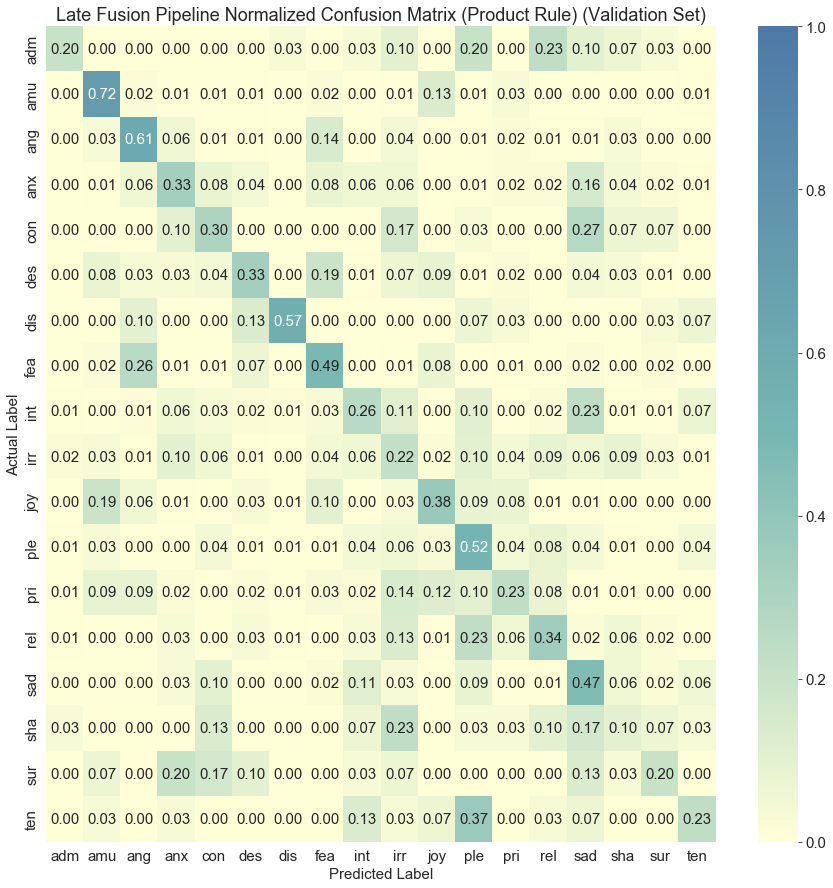

In [10]:
# Obtain X, y, and groups from the training dataset
X_audio_df = train_audio_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_audio_df = train_audio_shuffled_df.target
X_video_df = train_video_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_video_df = train_video_shuffled_df.target
groups = train_video_shuffled_df.group
n_groups = len(groups.unique())

logo = LeaveOneGroupOut()


# Initialize some variables to store results
results = []
AUC_train = []
AUC_val = []
UAR_train = []
UAR_val = []
conf_mat_avg = np.zeros([18,18])
for train_idx, val_idx in logo.split(X_audio_df, y_audio_df, groups):
    X_train_audio, X_val_audio, y_train, y_val = X_audio_df.iloc[train_idx], X_audio_df.iloc[val_idx], y_audio_df.iloc[train_idx], y_audio_df.iloc[val_idx]
    X_train_video, X_val_video, y_train, y_val = X_video_df.iloc[train_idx], X_video_df.iloc[val_idx], y_video_df.iloc[train_idx], y_video_df.iloc[val_idx]
    
    # Fit models and create pipeline
    audio_clf.fit(X_train_audio, y_train)
    video_clf.fit(X_train_video, y_train)
    pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf,
                                          video_clf   = video_clf,
                                          fusion_clf  = None,
                                          fusion_tech = 'prod'
                                         )
    
    # AUC - Compute results (training set)
    scores = pipe_late_fusion.predict_proba(X_audio_df = X_train_audio, # Predict probabilities
                                            X_video_df = X_train_video
                                           ) 
    AUC_tmp = roc_auc_score(y_true=y_train,                             # Compute AUC score
                            y_score=scores,
                            average='weighted',
                            multi_class='ovo')     
    AUC_train.append(AUC_tmp)     
    
    # UAR - Compute results (training set)
    predictions = pipe_late_fusion.predict(X_audio_df = X_train_audio,
                                           X_video_df = X_train_video)
    UAR_tmp = recall_score(y_true  = y_train,
                           y_pred  = predictions,
                           average = 'macro')
    UAR_train.append(UAR_tmp)
    
    
    # AUC - Compute results (validation set)
    scores = pipe_late_fusion.predict_proba(X_audio_df = X_val_audio, # Predict probabilities
                                            X_video_df = X_val_video
                                           ) 
    AUC_tmp = roc_auc_score(y_true=y_val,                             # Compute AUC score
                            y_score=scores,
                            average='weighted',
                            multi_class='ovo')     
    AUC_val.append(AUC_tmp)                                               # Add the new AUC to the array
    
    # UAR - Compute results (validation set)
    predictions = pipe_late_fusion.predict(X_audio_df = X_val_audio,
                                           X_video_df = X_val_video)
    UAR_tmp = recall_score(y_true  = y_val,
                           y_pred  = predictions,
                           average = 'macro')
    UAR_val.append(UAR_tmp)

    
    # Confusion Matrix - Compute results (validation set)
    y_pred = pipe_late_fusion.predict(X_audio_df = X_val_audio,       # Predict class
                                      X_video_df = X_val_video
                                     )                       
    conf_mat_tmp = confusion_matrix(y_val,                            # Compute confusion matrix for this batch
                                    y_pred,
                                    normalize='true'
                                    )
    conf_mat_avg += conf_mat_tmp    

AUC_train_avg, AUC_train_std = np.mean(AUC_train), np.std(AUC_train)   # Compute the arithmetic mean and the std of the AUC array (Training)
AUC_val_avg, AUC_val_std = np.mean(AUC_val), np.std(AUC_val)   # Compute the arithmetic mean and the std of the AUC array (Validation)
UAR_train_avg, UAR_train_std = np.mean(UAR_train), np.std(UAR_train)   # Compute the arithmetic mean and the std of the AUC array (Training)
UAR_val_avg, UAR_val_std = np.mean(UAR_val), np.std(UAR_val)   # Compute the arithmetic mean and the std of the AUC array (Validation)
conf_mat_avg /= n_groups # Compute the arithmetic mean of the confusion matrix

# Add results to the results list
results.append(['prod',                             # fusion_tech
                AUC_train_avg,
                AUC_train_std,
                AUC_val_avg,
                AUC_val_std,
                UAR_train_avg,
                UAR_train_std,
                UAR_val_avg,
                UAR_val_std
               ])

        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['fusion_tech','AUC_train_avg','AUC_train_std','AUC_val_avg','AUC_val_std','UAR_train_avg','UAR_train_std','UAR_val_avg','UAR_val_std'])
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_late_fusion_prod_'+str(n_groups)+'_logocv.csv'), index=None, header=True)
print('AUC_avg (train):', results_df['AUC_train_avg'].values[0])
print('AUC_std (train):', results_df['AUC_train_std'].values[0])
print('AUC_avg (validation):', results_df['AUC_val_avg'].values[0])
print('AUC_std (validation):', results_df['AUC_val_std'].values[0])
print('UAR_avg (train):', results_df['UAR_train_avg'].values[0])
print('UAR_std (train):', results_df['UAR_train_std'].values[0])
print('UAR_avg (validation):', results_df['UAR_val_avg'].values[0])
print('UAR_std (validation):', results_df['UAR_val_std'].values[0])

# Store the confusion matrix in a DataFrame and then plot it and save it
plot_save_conf_matrix(conf_mat_avg,
                      title = 'Late Fusion Pipeline Normalized Confusion Matrix (Product Rule) (Validation Set)',
                      file_name = 'conf_mat_pipeline_late_fusion_prod.svg',
                      report = True)

### Rule-based

AUC_avg (train): 0.9652892455974345
AUC_std (train): 0.0014617933502909786
AUC_avg (validation): 0.8469716849754944
AUC_std (validation): 0.01761573787272029
UAR_avg (train): 0.771633194227091
UAR_std (train): 0.011141027523610094
UAR_avg (validation): 0.29763979665940454
UAR_std (validation): 0.028017651312087936


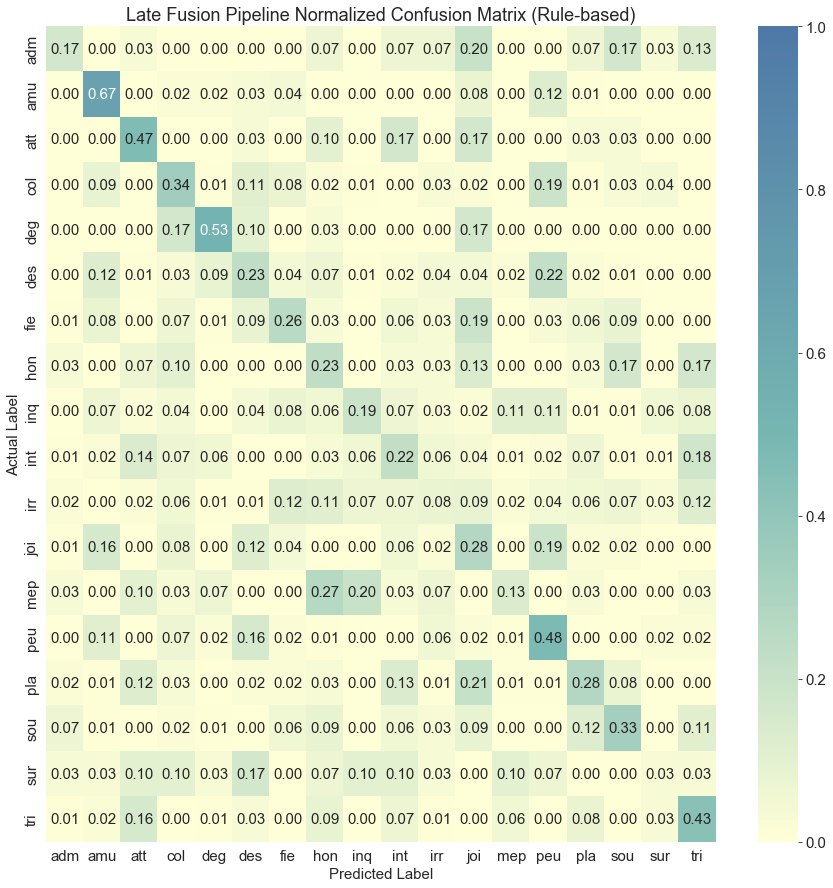

In [16]:
# Obtain X, y, and groups from the training dataset
X_audio_df = train_audio_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_audio_df = train_audio_shuffled_df.target
X_video_df = train_video_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_video_df = train_video_shuffled_df.target
groups = train_video_shuffled_df.group
n_groups = len(groups.unique())

logo = LeaveOneGroupOut()


# Initialize some variables to store results
results = []
AUC_train = []
AUC_val = []
UAR_train = []
UAR_val = []
conf_mat_avg = np.zeros([18,18])
for train_idx, val_idx in logo.split(X_audio_df, y_audio_df, groups):
    X_train_audio, X_val_audio, y_train, y_val = X_audio_df.iloc[train_idx], X_audio_df.iloc[val_idx], y_audio_df.iloc[train_idx], y_audio_df.iloc[val_idx]
    X_train_video, X_val_video, y_train, y_val = X_video_df.iloc[train_idx], X_video_df.iloc[val_idx], y_video_df.iloc[train_idx], y_video_df.iloc[val_idx]
    
    # Fit models and create pipeline
    audio_clf.fit(X_train_audio, y_train)
    video_clf.fit(X_train_video, y_train)
    pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf,
                                          video_clf   = video_clf,
                                          fusion_clf  = None,
                                          fusion_tech = 'rule'
                                         )
    
    # AUC - Compute results (training set)
    scores = pipe_late_fusion.predict_proba(X_audio_df = X_train_audio, # Predict probabilities
                                            X_video_df = X_train_video
                                           ) 
    AUC_tmp = roc_auc_score(y_true=y_train,                             # Compute AUC score
                            y_score=scores,
                            average='weighted',
                            multi_class='ovo')     
    AUC_train.append(AUC_tmp)     
    
    # UAR - Compute results (training set)
    predictions = pipe_late_fusion.predict(X_audio_df = X_train_audio,
                                           X_video_df = X_train_video)
    UAR_tmp = recall_score(y_true  = y_train,
                           y_pred  = predictions,
                           average = 'macro')
    UAR_train.append(UAR_tmp)
    
    # AUC - Compute results (validation set)
    scores = pipe_late_fusion.predict_proba(X_audio_df = X_val_audio, # Predict probabilities
                                            X_video_df = X_val_video
                                           ) 
    AUC_tmp = roc_auc_score(y_true=y_val,                             # Compute AUC score
                            y_score=scores,
                            average='weighted',
                            multi_class='ovo')     
    AUC_val.append(AUC_tmp)                                               # Add the new AUC to the array
    
    # UAR - Compute results (validation set)
    predictions = pipe_late_fusion.predict(X_audio_df = X_val_audio,
                                           X_video_df = X_val_video)
    UAR_tmp = recall_score(y_true  = y_val,
                           y_pred  = predictions,
                           average = 'macro')
    UAR_val.append(UAR_tmp)
    
    # Confusion Matrix - Compute results (validation set)
    y_pred = pipe_late_fusion.predict(X_audio_df = X_val_audio,       # Predict class
                                      X_video_df = X_val_video
                                     )                       
    conf_mat_tmp = confusion_matrix(y_val,                            # Compute confusion matrix for this batch
                                    y_pred,
                                    normalize='true'
                                    )
    conf_mat_avg += conf_mat_tmp    

AUC_train_avg, AUC_train_std = np.mean(AUC_train), np.std(AUC_train)   # Compute the arithmetic mean and the std of the AUC array (Training)
AUC_val_avg, AUC_val_std = np.mean(AUC_val), np.std(AUC_val)   # Compute the arithmetic mean and the std of the AUC array (Validation)
UAR_train_avg, UAR_train_std = np.mean(UAR_train), np.std(UAR_train)   # Compute the arithmetic mean and the std of the AUC array (Training)
UAR_val_avg, UAR_val_std = np.mean(UAR_val), np.std(UAR_val)   # Compute the arithmetic mean and the std of the AUC array (Validation)
conf_mat_avg /= n_groups # Compute the arithmetic mean of the confusion matrix

# Add results to the results list
results.append(['rule',                             # fusion_tech
                AUC_train_avg,
                AUC_train_std,
                AUC_val_avg,
                AUC_val_std,
                UAR_train_avg,
                UAR_train_std,
                UAR_val_avg,
                UAR_val_std
               ])

        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['fusion_tech','AUC_train_avg','AUC_train_std','AUC_val_avg','AUC_val_std','UAR_train_avg','UAR_train_std','UAR_val_avg','UAR_val_std'])
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_late_fusion_rule_'+str(n_groups)+'_logocv.csv'), index=None, header=True)
print('AUC_avg (train):', results_df['AUC_train_avg'].values[0])
print('AUC_std (train):', results_df['AUC_train_std'].values[0])
print('AUC_avg (validation):', results_df['AUC_val_avg'].values[0])
print('AUC_std (validation):', results_df['AUC_val_std'].values[0])
print('UAR_avg (train):', results_df['UAR_train_avg'].values[0])
print('UAR_std (train):', results_df['UAR_train_std'].values[0])
print('UAR_avg (validation):', results_df['UAR_val_avg'].values[0])
print('UAR_std (validation):', results_df['UAR_val_std'].values[0])

# Store the confusion matrix in a DataFrame and then plot it and save it
plot_save_conf_matrix(conf_mat_avg,
                      title = 'Late Fusion Pipeline Normalized Confusion Matrix (Rule-based)',
                      file_name = 'conf_mat_pipeline_late_fusion_rule.svg')

### Model-based

#### Elastic Net

In [13]:
from sklearn.linear_model import SGDClassifier

# Obtain X, y, and groups from the training dataset
X_audio_df = train_audio_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_audio_df = train_audio_shuffled_df.target
X_video_df = train_video_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_video_df = train_video_shuffled_df.target
groups = train_video_shuffled_df.group
n_groups = len(groups.unique())

logo = LeaveOneGroupOut()


# Define parameters to evaluate (fusion classifier)
alpha_values            = [0.0001, 0.00025, 0.0005, 0.00075, 0.001, 0.005, 0.0025, 0.0075, 0.01, 0.05, 0.1, 1]
l1_ratio_values         = [0.049, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50,
                           0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.89, 0.95, 0.99]
n_iter_no_change_values = [20, 50, 100, 150]
parameters              = [(alpha,l1_ratio,n_iter_no_change)  
                           for alpha in alpha_values
                           for l1_ratio in l1_ratio_values
                           for n_iter_no_change in n_iter_no_change_values
                          ]


# Initialize some variables to store results
results = []
AUC_best_model = 0
params_best_model = None
for i in tqdm(range(len(parameters))):
    AUC = []  
    fusion_clf = SGDClassifier(penalty          = 'elasticnet',
                               class_weight     = 'balanced',
                               loss             = 'log',
                               max_iter         = 2500,
                               alpha            = parameters[i][0],
                               l1_ratio         = parameters[i][1],
                               n_iter_no_change = parameters[i][2],
                               random_state     = seed,
                               n_jobs           = -1
                              )
    for train_idx, val_idx in logo.split(X_audio_df, y_audio_df, groups):
        X_train_audio, X_val_audio, y_train, y_val = X_audio_df.iloc[train_idx], X_audio_df.iloc[val_idx], y_audio_df.iloc[train_idx], y_audio_df.iloc[val_idx]
        X_train_video, X_val_video, y_train, y_val = X_video_df.iloc[train_idx], X_video_df.iloc[val_idx], y_video_df.iloc[train_idx], y_video_df.iloc[val_idx]
        
        # Fit models and create pipeline
        audio_clf.fit(X_train_audio, y_train)
        video_clf.fit(X_train_video, y_train)
        audio_scores = audio_clf.predict_proba(X_train_audio)
        video_scores = video_clf.predict_proba(X_train_video)
        multimodal_train_df = pd.DataFrame(data=np.column_stack((audio_scores,video_scores)), columns=['feature_'+str(x) for x in range(0,2*18)])
        fusion_clf.fit(multimodal_train_df, y_train.values)
        pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf,
                                              video_clf   = video_clf,
                                              fusion_clf  = fusion_clf,
                                              fusion_tech = 'clf'
                                             )
        
        
        # Compute results (validation dataset)
        scores = pipe_late_fusion.predict_proba(X_audio_df = X_val_audio, # Predict probabilities
                                                X_video_df = X_val_video
                                               ) 
        AUC_tmp = roc_auc_score(y_true=y_val,
                                y_score=scores,
                                average='weighted',
                                multi_class='ovo')                        # Get AUC score
        AUC.append(AUC_tmp)                                                # Add new AUC

    AUC_avg = np.mean(AUC)                                                # Get average AUC
    AUC_std = np.std(AUC)                                                 # Get std AUC
    AUC_avg_minus_std = AUC_avg - AUC_std
    
    # Add new results to the results list
    results.append(['elasticnet',                   # Penalty
                    parameters[i][0],               # Alpha
                    parameters[i][1],               # L1_ratio
                    parameters[i][2],               # n_iter_no_change
                    AUC_avg,
                    AUC_std,
                    AUC_avg_minus_std
                   ])
    
    # Check if current average AUC is better than the stored
    if AUC_avg_minus_std > AUC_best_model:
        AUC_best_model = AUC_avg_minus_std                # Update best average AUC
        params_best_model = parameters[i]           # Update best model parameters

    #break
        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['Penalty','Alpha','L1_ratio','n_iter_no_change','AUC_avg','AUC_std','AUC_avg_minus_std'])
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_late_fusion_clf_elastic_net_'+str(n_groups)+'_logocv.csv'), index=None, header=True)

100%|██████████| 960/960 [5:29:44<00:00, 20.61s/it]  


In [14]:
results_df.sort_values(by='AUC_avg_minus_std', ascending=False).head()

,Penalty,Alpha,L1_ratio,n_iter_no_change,AUC_avg,AUC_std,AUC_avg_minus_std
320,elasticnet,0.0010,0.049,20,0.869560,0.016834,0.852725
323,elasticnet,0.0010,0.049,150,0.869484,0.016831,0.852653
322,elasticnet,0.0010,0.049,100,0.869459,0.016856,0.852602
321,elasticnet,0.0010,0.049,50,0.869430,0.016891,0.852539
482,elasticnet,0.0025,0.049,100,0.869056,0.016695,0.852361


AUC_avg (train): 0.9994096902126731
AUC_std (train): 5.8352250437902485e-05
AUC_avg (validation): 0.869559704464032
AUC_std (validation): 0.01683428954976529
UAR_avg (train): 0.984104938271605
UAR_std (train): 0.0032590605064726835
UAR_avg (validation): 0.3087145969498911
UAR_std (validation): 0.049023050525979495


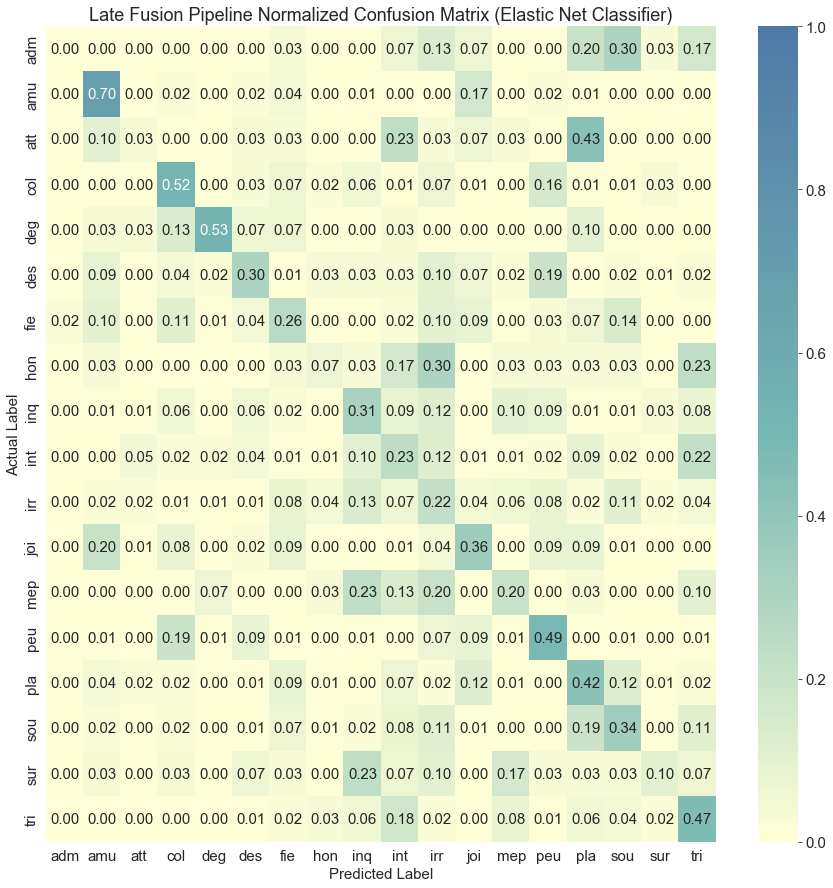

In [17]:
# Obtain X, y, and groups from the training dataset
X_audio_df = train_audio_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_audio_df = train_audio_shuffled_df.target
X_video_df = train_video_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_video_df = train_video_shuffled_df.target
groups = train_video_shuffled_df.group
n_groups = len(groups.unique())

logo = LeaveOneGroupOut()

# Load results and get the best one
results_df = pd.read_csv(os.path.join(output_path,'results','res_pipeline_late_fusion_clf_elastic_net_'+str(n_groups)+'_logocv.csv'))
res_tmp = results_df.sort_values(by='AUC_avg_minus_std', ascending=False).iloc[0]

fusion_clf = SGDClassifier(penalty          = 'elasticnet',
                           class_weight     = 'balanced',
                           loss             = 'log',
                           max_iter         = 2500,
                           alpha            = res_tmp['Alpha'],
                           l1_ratio         = res_tmp['L1_ratio'],
                           n_iter_no_change = res_tmp['n_iter_no_change'],
                           random_state     = seed,
                           n_jobs           = -1
                          )


# Initialize some variables to store results
conf_mat_avg = np.zeros([18,18])
AUC_train = []
AUC_val = []
UAR_train = []
UAR_val = []
for train_idx, val_idx in logo.split(X_audio_df, y_audio_df, groups):
    X_train_audio, X_val_audio, y_train, y_val = X_audio_df.iloc[train_idx], X_audio_df.iloc[val_idx], y_audio_df.iloc[train_idx], y_audio_df.iloc[val_idx]
    X_train_video, X_val_video, y_train, y_val = X_video_df.iloc[train_idx], X_video_df.iloc[val_idx], y_video_df.iloc[train_idx], y_video_df.iloc[val_idx]
     
    # Fit models and create pipeline
    audio_clf.fit(X_train_audio, y_train)
    video_clf.fit(X_train_video, y_train)
    audio_scores = audio_clf.predict_proba(X_train_audio)
    video_scores = video_clf.predict_proba(X_train_video)
    multimodal_train_df = pd.DataFrame(data=np.column_stack((audio_scores,video_scores)), columns=['feature_'+str(x) for x in range(0,2*18)])
    fusion_clf.fit(multimodal_train_df, y_train.values)
    pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf,
                                          video_clf   = video_clf,
                                          fusion_clf  = fusion_clf,
                                          fusion_tech = 'clf'
                                         )
    
    # AUC - training
    scores = pipe_late_fusion.predict_proba(X_audio_df = X_train_audio, # Predict probabilities
                                            X_video_df = X_train_video
                                           ) 
    AUC_tmp = roc_auc_score(y_true=y_train,
                            y_score=scores,
                            average='weighted',
                            multi_class='ovo')                        # Get AUC score
    AUC_train.append(AUC_tmp)                                         # Add new AUC
    
    # UAR - Compute results (training set)
    predictions = pipe_late_fusion.predict(X_audio_df = X_train_audio,
                                           X_video_df = X_train_video)
    UAR_tmp = recall_score(y_true  = y_train,
                           y_pred  = predictions,
                           average = 'macro')
    UAR_train.append(UAR_tmp)
    
    # AUC - validation
    scores = pipe_late_fusion.predict_proba(X_audio_df = X_val_audio, # Predict probabilities
                                            X_video_df = X_val_video
                                           ) 
    AUC_tmp = roc_auc_score(y_true=y_val,
                            y_score=scores,
                            average='weighted',
                            multi_class='ovo')                        # Get AUC score
    AUC_val.append(AUC_tmp)                                           # Add new AUC
    
    # UAR - Compute results (validation set)
    predictions = pipe_late_fusion.predict(X_audio_df = X_val_audio,
                                           X_video_df = X_val_video)
    UAR_tmp = recall_score(y_true  = y_val,
                           y_pred  = predictions,
                           average = 'macro')
    UAR_val.append(UAR_tmp)    
    
    # Confusion Matrix - Compute results (validation set)
    y_pred = pipe_late_fusion.predict(X_audio_df = X_val_audio,       # Predict class
                                      X_video_df = X_val_video
                                     )                       
    conf_mat_tmp = confusion_matrix(y_val,                            # Compute confusion matrix for this batch
                                    y_pred,
                                    normalize='true'
                                    )
    conf_mat_avg += conf_mat_tmp    
         
        
# Calculate final results: confusion matrix, AUC (train), AUC (test)
conf_mat_avg /= n_groups # Compute the arithmetic mean of the confusion matrix
auc_train_avg, auc_train_std = np.mean(AUC_train), np.std(AUC_train)
auc_val_avg, auc_val_std = np.mean(AUC_val), np.std(AUC_val)
uar_train_avg, uar_train_std = np.mean(UAR_train), np.std(UAR_train)   # Compute the arithmetic mean and the std of the AUC array (Training)
uar_val_avg, uar_val_std = np.mean(UAR_val), np.std(UAR_val)   # Compute the arithmetic mean and the std of the AUC array (Validation)


# Plot AUCs
print('AUC_avg (train):', auc_train_avg)
print('AUC_std (train):', auc_train_std)
print('AUC_avg (validation):', auc_val_avg)
print('AUC_std (validation):', auc_val_std)
print('UAR_avg (train):', uar_train_avg)
print('UAR_std (train):', uar_train_std)
print('UAR_avg (validation):', uar_val_avg)
print('UAR_std (validation):', uar_val_std)

# Store the confusion matrix in a DataFrame and then plot it and save it
plot_save_conf_matrix(conf_mat_avg,
                      title      = 'Late Fusion Pipeline Normalized Confusion Matrix (Elastic Net Classifier)',
                      file_name = 'conf_mat_pipeline_late_fusion_clf_elastic_net.svg')

#### kNN Classifier

In [14]:
from sklearn.neighbors import KNeighborsClassifier

# Obtain X, y, and groups from the training dataset
X_audio_df = train_audio_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_audio_df = train_audio_shuffled_df.target
X_video_df = train_video_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_video_df = train_video_shuffled_df.target
groups = train_video_shuffled_df.group
n_groups = len(groups.unique())

logo = LeaveOneGroupOut()


# Define parameters to evaluate (fusion classifier)
n_neigh_values   = np.arange(1, 905, 5).tolist()
leaf_size_values = [10, 20, 30]
weights_values   = ['uniform']
algorithm_values = ['ball_tree','brute', 'kd_tree']
metric_values    = ['manhattan']
parameters       = [(n_neighbors,leaf_size,weights,algorithm,metric)
                    for n_neighbors in n_neigh_values
                    for leaf_size in leaf_size_values
                    for weights in weights_values
                    for algorithm in algorithm_values
                    for metric in metric_values
                   ]


# Initialize some variables to store results
results = []
AUC_best_model = 0
params_best_model = None
for i in tqdm(range(len(parameters))):
    AUC = []  
    fusion_clf = KNeighborsClassifier(n_neighbors  = parameters[i][0],
                                      leaf_size    = parameters[i][1],
                                      weights      = parameters[i][2],
                                      algorithm    = parameters[i][3],
                                      metric       = parameters[i][4],
                                      n_jobs       = -1
                                     )
    for train_idx, val_idx in logo.split(X_audio_df, y_audio_df, groups):
        X_train_audio, X_val_audio, y_train, y_val = X_audio_df.iloc[train_idx], X_audio_df.iloc[val_idx], y_audio_df.iloc[train_idx], y_audio_df.iloc[val_idx]
        X_train_video, X_val_video, y_train, y_val = X_video_df.iloc[train_idx], X_video_df.iloc[val_idx], y_video_df.iloc[train_idx], y_video_df.iloc[val_idx]
        
        # Fit models and create pipeline
        audio_clf.fit(X_train_audio, y_train)
        video_clf.fit(X_train_video, y_train)
        audio_scores = audio_clf.predict_proba(X_train_audio)
        video_scores = video_clf.predict_proba(X_train_video)
        multimodal_train_df = pd.DataFrame(data=np.column_stack((audio_scores,video_scores)), columns=['feature_'+str(x) for x in range(0,2*18)])
        fusion_clf.fit(multimodal_train_df, y_train.values)
        pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf,
                                              video_clf   = video_clf,
                                              fusion_clf  = fusion_clf,
                                              fusion_tech = 'clf'
                                             )
        
        
        # Compute results (validation dataset)
        scores = pipe_late_fusion.predict_proba(X_audio_df = X_val_audio, # Predict probabilities
                                                X_video_df = X_val_video
                                               ) 
        AUC_tmp = roc_auc_score(y_true=y_val,
                                y_score=scores,
                                average='weighted',
                                multi_class='ovo')                        # Get AUC score
        AUC.append(AUC_tmp)                                                # Add new AUC

    AUC_avg = np.mean(AUC)                                                # Get average AUC
    AUC_std = np.std(AUC)                                                 # Get std AUC
    AUC_avg_minus_std = AUC_avg - AUC_std
    
    # Add new results to the results list
    results.append([parameters[i][0],  # n_neighbors
                    parameters[i][1],  # leaf_size
                    parameters[i][2],  # weights
                    parameters[i][3],  # algorithm
                    parameters[i][4],  # metric
                    AUC_avg,
                    AUC_std,
                    AUC_avg_minus_std
                    ])
    
    # Check if current average AUC is better than the stored
    if AUC_avg_minus_std > AUC_best_model:
        AUC_best_model = AUC_avg_minus_std                # Update best average AUC
        params_best_model = parameters[i]           # Update best model parameters

    #break
        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['k_neighbors','leaf_size','weights','algorithm','metric','AUC_avg','AUC_std','AUC_avg_minus_std'])
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_late_fusion_clf_knn_'+str(n_groups)+'_logocv.csv'), index=None, header=True)

100%|██████████| 1629/1629 [9:02:46<00:00, 19.99s/it]  


In [15]:
results_df.sort_values(by='AUC_avg_minus_std', ascending=False).head()

,k_neighbors,leaf_size,weights,algorithm,metric,AUC_avg,AUC_std,AUC_avg_minus_std
640,356,10,uniform,brute,manhattan,0.858533,0.01599,0.842543
641,356,10,uniform,kd_tree,manhattan,0.858533,0.01599,0.842543
642,356,20,uniform,ball_tree,manhattan,0.858533,0.01599,0.842543
643,356,20,uniform,brute,manhattan,0.858533,0.01599,0.842543
644,356,20,uniform,kd_tree,manhattan,0.858533,0.01599,0.842543


AUC_avg (train): 0.9825357133177327
AUC_std (train): 0.0007546599659843888
AUC_avg (validation): 0.8585328076147958
AUC_std (validation): 0.015989651361863116
UAR_avg (train): 0.5379955659885238
UAR_std (train): 0.008676245494848746
UAR_avg (validation): 0.25831517792302106
UAR_std (validation): 0.03441097369025741


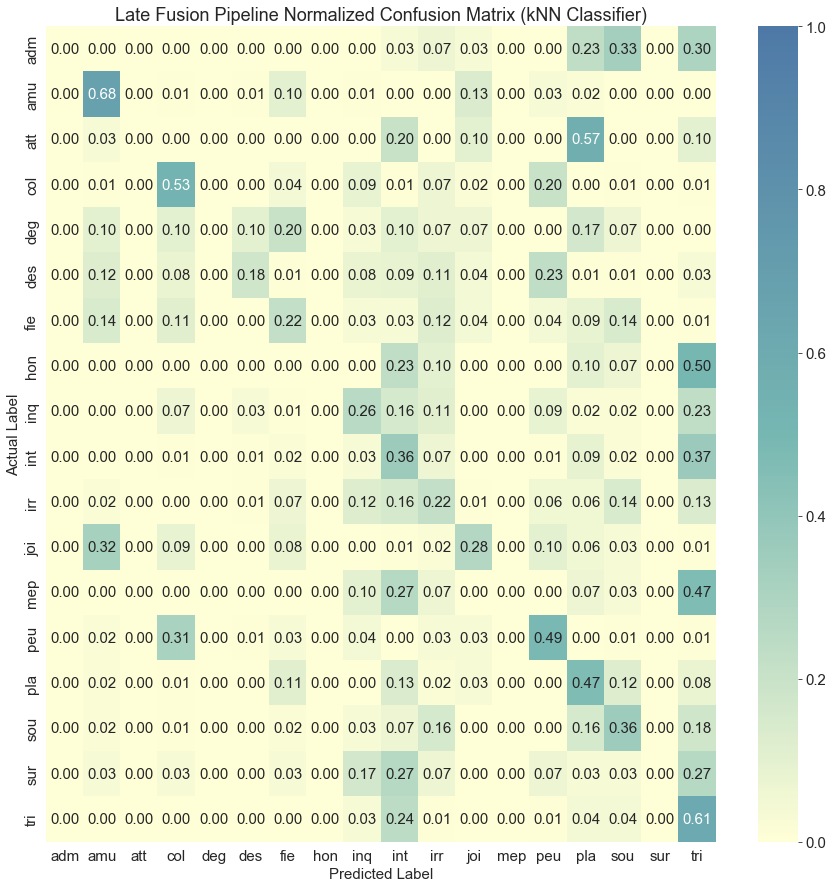

In [18]:
from sklearn.neighbors import KNeighborsClassifier

# Obtain X, y, and groups from the training dataset
X_audio_df = train_audio_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_audio_df = train_audio_shuffled_df.target
X_video_df = train_video_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_video_df = train_video_shuffled_df.target
groups = train_video_shuffled_df.group
n_groups = len(groups.unique())

logo = LeaveOneGroupOut()

# Load results and get the best one
results_df = pd.read_csv(os.path.join(output_path,'results','res_pipeline_late_fusion_clf_knn_'+str(n_groups)+'_logocv.csv'))
res_tmp = results_df.sort_values(by='AUC_avg_minus_std', ascending=False).iloc[0]

fusion_clf = KNeighborsClassifier(n_neighbors  = res_tmp['k_neighbors'],
                                  leaf_size    = res_tmp['leaf_size'],
                                  weights      = res_tmp['weights'],
                                  algorithm    = res_tmp['algorithm'],
                                  metric       = res_tmp['metric'],
                                  n_jobs       = -1
                                 )


# Initialize some variables to store results
conf_mat_avg = np.zeros([18,18])
AUC_train = []
AUC_val = []
UAR_train = []
UAR_val = []
for train_idx, val_idx in logo.split(X_audio_df, y_audio_df, groups):
    X_train_audio, X_val_audio, y_train, y_val = X_audio_df.iloc[train_idx], X_audio_df.iloc[val_idx], y_audio_df.iloc[train_idx], y_audio_df.iloc[val_idx]
    X_train_video, X_val_video, y_train, y_val = X_video_df.iloc[train_idx], X_video_df.iloc[val_idx], y_video_df.iloc[train_idx], y_video_df.iloc[val_idx]
     
    # Fit models and create pipeline
    audio_clf.fit(X_train_audio, y_train)
    video_clf.fit(X_train_video, y_train)
    audio_scores = audio_clf.predict_proba(X_train_audio)
    video_scores = video_clf.predict_proba(X_train_video)
    multimodal_train_df = pd.DataFrame(data=np.column_stack((audio_scores,video_scores)), columns=['feature_'+str(x) for x in range(0,2*18)])
    fusion_clf.fit(multimodal_train_df, y_train.values)
    pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf,
                                          video_clf   = video_clf,
                                          fusion_clf  = fusion_clf,
                                          fusion_tech = 'clf'
                                         )
    
    # AUC - training
    scores = pipe_late_fusion.predict_proba(X_audio_df = X_train_audio, # Predict probabilities
                                            X_video_df = X_train_video
                                           ) 
    AUC_tmp = roc_auc_score(y_true=y_train,
                            y_score=scores,
                            average='weighted',
                            multi_class='ovo')                        # Get AUC score
    AUC_train.append(AUC_tmp)                                         # Add new AUC
    
    # UAR - Compute results (training set)
    predictions = pipe_late_fusion.predict(X_audio_df = X_train_audio,
                                           X_video_df = X_train_video)
    UAR_tmp = recall_score(y_true  = y_train,
                           y_pred  = predictions,
                           average = 'macro')
    UAR_train.append(UAR_tmp)
    
    # AUC - validation
    scores = pipe_late_fusion.predict_proba(X_audio_df = X_val_audio, # Predict probabilities
                                            X_video_df = X_val_video
                                           ) 
    AUC_tmp = roc_auc_score(y_true=y_val,
                            y_score=scores,
                            average='weighted',
                            multi_class='ovo')                        # Get AUC score
    AUC_val.append(AUC_tmp)                                           # Add new AUC
    
    # UAR - Compute results (validation set)
    predictions = pipe_late_fusion.predict(X_audio_df = X_val_audio,
                                           X_video_df = X_val_video)
    UAR_tmp = recall_score(y_true  = y_val,
                           y_pred  = predictions,
                           average = 'macro')
    UAR_val.append(UAR_tmp)
    
    # Confusion Matrix - Compute results (validation set)
    y_pred = pipe_late_fusion.predict(X_audio_df = X_val_audio,       # Predict class
                                      X_video_df = X_val_video
                                     )                       
    conf_mat_tmp = confusion_matrix(y_val,                            # Compute confusion matrix for this batch
                                    y_pred,
                                    normalize='true'
                                    )
    conf_mat_avg += conf_mat_tmp    
         
        
# Calculate final results: confusion matrix, AUC (train), AUC (test)
conf_mat_avg /= n_groups # Compute the arithmetic mean of the confusion matrix
auc_train_avg, auc_train_std = np.mean(AUC_train), np.std(AUC_train)
auc_val_avg, auc_val_std = np.mean(AUC_val), np.std(AUC_val)
uar_train_avg, uar_train_std = np.mean(UAR_train), np.std(UAR_train)   # Compute the arithmetic mean and the std of the AUC array (Training)
uar_val_avg, uar_val_std = np.mean(UAR_val), np.std(UAR_val)   # Compute the arithmetic mean and the std of the AUC array (Validation)

# Plot AUCs
print('AUC_avg (train):', auc_train_avg)
print('AUC_std (train):', auc_train_std)
print('AUC_avg (validation):', auc_val_avg)
print('AUC_std (validation):', auc_val_std)
print('UAR_avg (train):', uar_train_avg)
print('UAR_std (train):', uar_train_std)
print('UAR_avg (validation):', uar_val_avg)
print('UAR_std (validation):', uar_val_std)

# Store the confusion matrix in a DataFrame and then plot it and save it
plot_save_conf_matrix(conf_mat_avg,
                      title      = 'Late Fusion Pipeline Normalized Confusion Matrix (kNN Classifier)',
                      file_name = 'conf_mat_pipeline_late_fusion_clf_knn.svg')

#### Decision Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

# Obtain X, y, and groups from the training dataset
X_audio_df = train_audio_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_audio_df = train_audio_shuffled_df.target
X_video_df = train_video_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_video_df = train_video_shuffled_df.target
groups = train_video_shuffled_df.group
n_groups = len(groups.unique())

logo = LeaveOneGroupOut()

# Define parameters to evaluate (fusing classifier)
criterion_values         = ['gini', 'entropy']
splitter_values          = ['best', 'random']
max_depth_values         = np.arange(5, 55, 5).tolist()
min_samples_split_values = np.linspace(0.1, 1.0, 10, endpoint=True)
min_samples_leaf_values  = np.linspace(0.1, 0.5, 5, endpoint=True)
max_features_values      = [int(x) for x in np.linspace(1, 18*2, num = 18)] #list(range(1,len(X.columns)))
parameters = [(criterion,splitter,max_depth,min_samples_split,min_samples_leaf,max_features)  
              for criterion in criterion_values
              for splitter in splitter_values
              for max_depth in max_depth_values
              for min_samples_split in min_samples_split_values
              for min_samples_leaf in min_samples_leaf_values
              for max_features in max_features_values
             ]


# Randomized Search CV (we need randomize search beacuse there are a lot of combinations)
parameters = resample(parameters, n_samples=900, replace=False, random_state=seed)


# Initialize some variables to store results
results = []
AUC_best_model = 0
params_best_model = None
for i in tqdm(range(len(parameters))):
    AUC = []  
    fusion_clf = DecisionTreeClassifier(criterion         = parameters[i][0],
                                        splitter          = parameters[i][1],
                                        max_depth         = parameters[i][2],
                                        min_samples_split = parameters[i][3],
                                        min_samples_leaf  = parameters[i][4],
                                        max_features      = parameters[i][5],
                                        class_weight      = 'balanced',
                                        random_state      = seed
                                       )
    for train_idx, val_idx in logo.split(X_audio_df, y_audio_df, groups):
        X_train_audio, X_val_audio, y_train, y_val = X_audio_df.iloc[train_idx], X_audio_df.iloc[val_idx], y_audio_df.iloc[train_idx], y_audio_df.iloc[val_idx]
        X_train_video, X_val_video, y_train, y_val = X_video_df.iloc[train_idx], X_video_df.iloc[val_idx], y_video_df.iloc[train_idx], y_video_df.iloc[val_idx]
        
        # Fit models and create pipeline
        audio_clf.fit(X_train_audio, y_train)
        video_clf.fit(X_train_video, y_train)
        audio_scores = audio_clf.predict_proba(X_train_audio)
        video_scores = video_clf.predict_proba(X_train_video)
        multimodal_train_df = pd.DataFrame(data=np.column_stack((audio_scores,video_scores)), columns=['feature_'+str(x) for x in range(0,2*18)])
        fusion_clf.fit(multimodal_train_df, y_train.values)
        pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf,
                                              video_clf   = video_clf,
                                              fusion_clf  = fusion_clf,
                                              fusion_tech = 'clf'
                                             )
        
        
        # Compute results (validation dataset)
        scores = pipe_late_fusion.predict_proba(X_audio_df = X_val_audio, # Predict probabilities
                                                X_video_df = X_val_video
                                               ) 
        AUC_tmp = roc_auc_score(y_true=y_val,
                                y_score=scores,
                                average='weighted',
                                multi_class='ovo')                        # Get AUC score
        AUC.append(AUC_tmp)                                                # Add new AUC

    AUC_avg = np.mean(AUC)                                                # Get average AUC
    AUC_std = np.std(AUC)                                                 # Get std AUC
    AUC_avg_minus_std = AUC_avg - AUC_std
    
    # Add new results to the results list
    results.append([parameters[i][0],                 # criterion
                    parameters[i][1],                 # splitter
                    parameters[i][2],                 # max_depth
                    parameters[i][3],                 # min_samples_split
                    parameters[i][4],                 # min_samples_leaf
                    parameters[i][5],                 # max_features
                    AUC_avg,
                    AUC_std,
                    AUC_avg_minus_std
                    ])
    
    # Check if current average AUC is better than the stored
    if AUC_avg_minus_std > AUC_best_model:
        AUC_best_model = AUC_avg_minus_std                # Update best average AUC
        params_best_model = parameters[i]           # Update best model parameters

    #break
        
# Store the results in a DataFrame and then save them as csv
results_df = pd.DataFrame(data=results, columns=['criterion','splitter','max_depth','min_samples_split','min_samples_leaf','max_features','AUC_avg','AUC_std','AUC_avg_minus_std'])
results_df.to_csv(os.path.join(output_path,'results','res_pipeline_late_fusion_clf_tree_'+str(n_groups)+'_logocv.csv'), index=None, header=True)

100%|██████████| 900/900 [4:44:05<00:00, 18.94s/it]  


In [20]:
results_df.sort_values(by='AUC_avg_minus_std', ascending=False).head()

,criterion,splitter,max_depth,min_samples_split,min_samples_leaf,max_features,AUC_avg,AUC_std,AUC_avg_minus_std
524,entropy,best,15,0.1,0.1,5,0.707946,0.026667,0.681280
425,entropy,best,50,0.2,0.1,5,0.707946,0.026667,0.681280
439,entropy,best,20,0.2,0.1,9,0.701379,0.020362,0.681016
690,entropy,best,45,0.1,0.1,15,0.703400,0.032733,0.670667
416,entropy,best,45,0.4,0.2,7,0.694308,0.025191,0.669117


AUC_avg (train): 0.8042050683695747
AUC_std (train): 0.009570525594052878
AUC_avg (validation): 0.7079464265807704
AUC_std (validation): 0.02666671643190037
UAR_avg (train): 0.260545992001391
UAR_std (train): 0.01726240027091563
UAR_avg (validation): 0.1722222222222222
UAR_std (validation): 0.030454065144553108


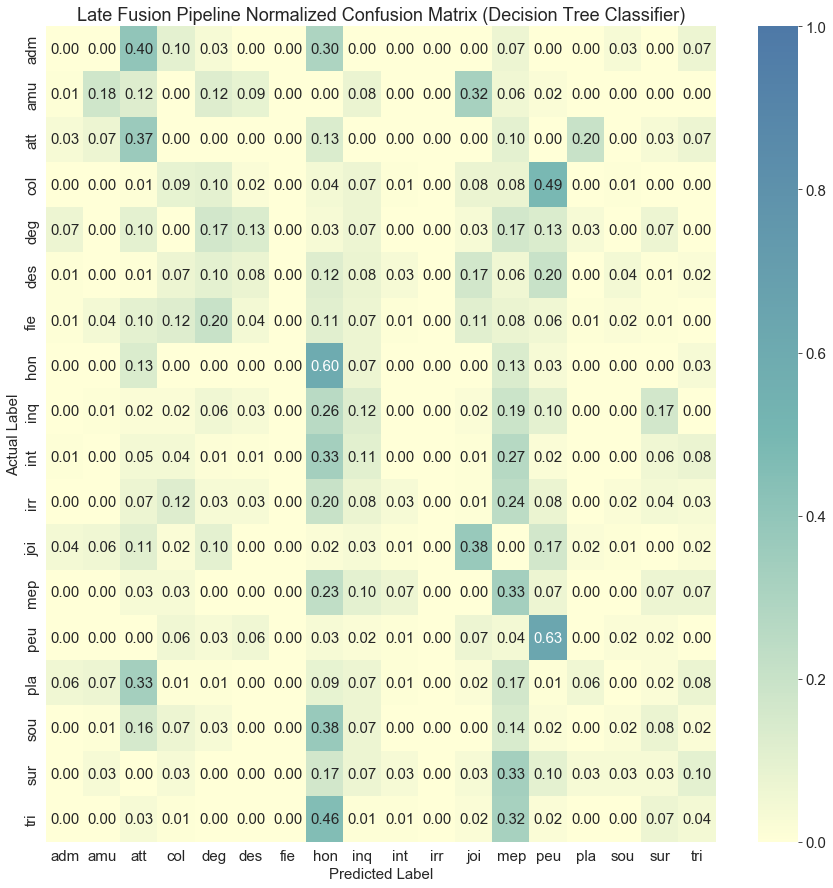

In [19]:
from sklearn.tree import DecisionTreeClassifier

# Obtain X, y, and groups from the training dataset
X_audio_df = train_audio_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_audio_df = train_audio_shuffled_df.target
X_video_df = train_video_shuffled_df.drop(['target','file_id','actor_id','group'], axis=1)
y_video_df = train_video_shuffled_df.target
groups = train_video_shuffled_df.group
n_groups = len(groups.unique())

logo = LeaveOneGroupOut()

# Load results and get the best one
results_df = pd.read_csv(os.path.join(output_path,'results','res_pipeline_late_fusion_clf_tree_'+str(n_groups)+'_logocv.csv'))
res_tmp = results_df.sort_values(by='AUC_avg_minus_std', ascending=False).iloc[0]

fusion_clf = DecisionTreeClassifier(criterion         = res_tmp['criterion'],
                                    splitter          = res_tmp['splitter'],
                                    max_depth         = res_tmp['max_depth'],
                                    min_samples_split = res_tmp['min_samples_split'],
                                    min_samples_leaf  = res_tmp['min_samples_leaf'],
                                    max_features      = res_tmp['max_features'],
                                    class_weight      = 'balanced',
                                    random_state      = seed                                    
                                   )


# Initialize some variables to store results
conf_mat_avg = np.zeros([18,18])
AUC_train = []
AUC_val = []
UAR_train = []
UAR_val = []
for train_idx, val_idx in logo.split(X_audio_df, y_audio_df, groups):
    X_train_audio, X_val_audio, y_train, y_val = X_audio_df.iloc[train_idx], X_audio_df.iloc[val_idx], y_audio_df.iloc[train_idx], y_audio_df.iloc[val_idx]
    X_train_video, X_val_video, y_train, y_val = X_video_df.iloc[train_idx], X_video_df.iloc[val_idx], y_video_df.iloc[train_idx], y_video_df.iloc[val_idx]
     
    # Fit models and create pipeline
    audio_clf.fit(X_train_audio, y_train)
    video_clf.fit(X_train_video, y_train)
    audio_scores = audio_clf.predict_proba(X_train_audio)
    video_scores = video_clf.predict_proba(X_train_video)
    multimodal_train_df = pd.DataFrame(data=np.column_stack((audio_scores,video_scores)), columns=['feature_'+str(x) for x in range(0,2*18)])
    fusion_clf.fit(multimodal_train_df, y_train.values)
    pipe_late_fusion = PipelineLateFusion(audio_clf   = audio_clf,
                                          video_clf   = video_clf,
                                          fusion_clf  = fusion_clf,
                                          fusion_tech = 'clf'
                                         )
    
    # AUC - training
    scores = pipe_late_fusion.predict_proba(X_audio_df = X_train_audio, # Predict probabilities
                                            X_video_df = X_train_video
                                           ) 
    AUC_tmp = roc_auc_score(y_true=y_train,
                            y_score=scores,
                            average='weighted',
                            multi_class='ovo')                        # Get AUC score
    AUC_train.append(AUC_tmp)                                         # Add new AUC
    
    # UAR - Compute results (training set)
    predictions = pipe_late_fusion.predict(X_audio_df = X_train_audio,
                                           X_video_df = X_train_video)
    UAR_tmp = recall_score(y_true  = y_train,
                           y_pred  = predictions,
                           average = 'macro')
    UAR_train.append(UAR_tmp)
    
    # AUC - validation
    scores = pipe_late_fusion.predict_proba(X_audio_df = X_val_audio, # Predict probabilities
                                            X_video_df = X_val_video
                                           ) 
    AUC_tmp = roc_auc_score(y_true=y_val,
                            y_score=scores,
                            average='weighted',
                            multi_class='ovo')                        # Get AUC score
    AUC_val.append(AUC_tmp)                                           # Add new AUC
    
    # UAR - Compute results (validation set)
    predictions = pipe_late_fusion.predict(X_audio_df = X_val_audio,
                                           X_video_df = X_val_video)
    UAR_tmp = recall_score(y_true  = y_val,
                           y_pred  = predictions,
                           average = 'macro')
    UAR_val.append(UAR_tmp)
    
    
    # Confusion Matrix - Compute results (validation set)
    y_pred = pipe_late_fusion.predict(X_audio_df = X_val_audio,       # Predict class
                                      X_video_df = X_val_video
                                     )                       
    conf_mat_tmp = confusion_matrix(y_val,                            # Compute confusion matrix for this batch
                                    y_pred,
                                    normalize='true'
                                    )
    conf_mat_avg += conf_mat_tmp    
         
        
# Calculate final results: confusion matrix, AUC (train), AUC (test)
conf_mat_avg /= n_groups # Compute the arithmetic mean of the confusion matrix
auc_train_avg, auc_train_std = np.mean(AUC_train), np.std(AUC_train)
auc_val_avg, auc_val_std = np.mean(AUC_val), np.std(AUC_val)
uar_train_avg, uar_train_std = np.mean(UAR_train), np.std(UAR_train)   # Compute the arithmetic mean and the std of the AUC array (Training)
uar_val_avg, uar_val_std = np.mean(UAR_val), np.std(UAR_val)   # Compute the arithmetic mean and the std of the AUC array (Validation)

# Plot AUCs
print('AUC_avg (train):', auc_train_avg)
print('AUC_std (train):', auc_train_std)
print('AUC_avg (validation):', auc_val_avg)
print('AUC_std (validation):', auc_val_std)
print('UAR_avg (train):', uar_train_avg)
print('UAR_std (train):', uar_train_std)
print('UAR_avg (validation):', uar_val_avg)
print('UAR_std (validation):', uar_val_std)

# Store the confusion matrix in a DataFrame and then plot it and save it
plot_save_conf_matrix(conf_mat_avg,
                      title      = 'Late Fusion Pipeline Normalized Confusion Matrix (Decision Tree Classifier)',
                      file_name = 'conf_mat_pipeline_late_fusion_clf_tree.svg')

# 